In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [1]:
import torch

In [ ]:
torch.load()

In [ ]:
import os

root_dir = "/external2/dkkoshman/repos/ML2TransformerApp/data"
a = sorted(
    set(
        os.path.splitext(filename)[0]
        for filename in os.listdir(root_dir)
        if filename.endswith(".png")
    )
)[:10]
os.path.join(root_dir, a[0] + ".png")

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

root = "../datasets/CIFAR10"

train_data = torchvision.datasets.CIFAR10(
    root=root, train=True, download=True, transform=transform
)

test_data = torchvision.datasets.CIFAR10(
    root=root, train=False, download=True, transform=transform
)

batch_size = 64
num_workers = 2

train_dataloader = torch.utils.data.DataLoader(
    train_data, shuffle=True, batch_size=batch_size, num_workers=0
)

test_dataloader = torch.utils.data.DataLoader(
    test_data, shuffle=True, batch_size=batch_size, num_workers=0
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class MobileNet(nn.Module):
    """Small net for image related tasks"""

    def __init__(self, input_width, classes_count, input_channels=3, width=32):
        """
        Parameters
        ----------
        input_width: int
            input images will be scaled to have this width
        classes_count: int
            number of classes to predict
        input_channels: int
            number of channels in input images
        width: int
            width of first internal representation
        """

        super(MobileNet, self).__init__()
        self.input_width = input_width
        self.classes_count = classes_count
        self.input_channels = input_channels
        self.width = width

        self.transform = torchvision.transforms.Resize(input_width)

        def DepthwiseSeparableConv(in_channels, out_channels, stride):
            return nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    in_channels,
                    kernel_size=3,
                    stride=stride,
                    padding=1,
                    groups=in_channels,
                    bias=False,
                ),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )

        self.layers = nn.Sequential(
            nn.Conv2d(
                input_channels, width, kernel_size=3, stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(width),
            nn.ReLU(),
            DepthwiseSeparableConv(width * 1, width * 2, 1),
            DepthwiseSeparableConv(width * 2, width * 4, 2),
            DepthwiseSeparableConv(width * 4, width * 4, 1),
            DepthwiseSeparableConv(width * 4, width * 8, 2),
            DepthwiseSeparableConv(width * 8, width * 8, 1),
            DepthwiseSeparableConv(width * 8, width * 16, 2),
            DepthwiseSeparableConv(width * 16, width * 16, 1),
            DepthwiseSeparableConv(width * 16, width * 16, 1),
            DepthwiseSeparableConv(width * 16, width * 16, 1),
            DepthwiseSeparableConv(width * 16, width * 16, 1),
            DepthwiseSeparableConv(width * 16, width * 16, 1),
            DepthwiseSeparableConv(width * 16, width * 32, 2),
            DepthwiseSeparableConv(width * 32, width * 32, 1),
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(width * 32, classes_count, kernel_size=1),
            nn.Softmax2d(),
        )

    def forward(self, x):
        x = self.transform(x)
        x = self.layers(x)
        x = torch.squeeze(x)
        return x

In [5]:
import IPython
from math import ceil
from tqdm import tqdm


def train_loop(model, dataloader, loss_fn, optimizer, step=0.05):
    out = display(IPython.display.Pretty("Learning..."), display_id=True)

    size = len(dataloader.dataset)
    len_size = len(str(size))
    train_loss, correct = 0, 0
    batches = ceil(size / dataloader.batch_size) - 1

    percentage = 0
    for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
        X, y = X.to(device), y.to(device)

        # evaluate
        model.train()
        optimizer.zero_grad()
        f = model(X)
        loss = loss_fn(f, y)
        train_loss += loss
        correct += (f.argmax(axis=1) == y).sum().item()

        # backpropagation
        loss.backward()
        optimizer.step()

        # print info
        if batch / batches > percentage or batch == batches:
            out.update(f"[{int(percentage * size)}/{size}] Loss: {loss:>8f}")
            percentage += step

    train_loss /= batches
    correct /= size
    return {"train_acc": correct, "train_loss": train_loss.item()}


def test_loop(model, dataloader, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    batches = ceil(size / dataloader.batch_size)

    with torch.no_grad():
        # evalute and check predictions
        model.eval()
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            f = model(X)
            test_loss += loss_fn(f, y)
            correct += (f.argmax(axis=1) == y).sum().item()

    test_loss /= batches
    correct /= size

    print(
        f"Validation accuracy: {(100*correct):>0.1f}%, Validation loss: {test_loss:>8f} \n"
    )
    return {"val_acc": correct, "val_loss": test_loss.item()}

In [6]:
class ModelInstance:
    def __init__(self, train_dataloader, test_dataloader, model, optimizer, loss_fn):
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn

        self.train_acc = []
        self.train_loss = []
        self.test_acc = []
        self.test_loss = []

    def run(self, epochs):
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}\n-------------------------------")
            train_history = train_loop(
                self.model, self.train_dataloader, self.loss_fn, self.optimizer
            )
            test_history = test_loop(self.model, self.test_dataloader, self.loss_fn)

            self.train_acc.append(train_history["train_acc"])
            self.train_loss.append(train_history["train_loss"])
            self.test_acc.append(test_history["val_acc"])
            self.test_loss.append(test_history["val_loss"])

    def plot(self):
        fig, ax = plt.subplots(1, 2, figsize=(16, 6))

        ax[0].set_title("Accuracy")
        ax[0].plot(self.train_acc, label="train_acc")
        ax[0].plot(self.test_acc, label="test_acc")
        ax[0].legend()
        ax[0].set_xlabel("Epoch")

        ax[1].set_title("Loss")
        ax[1].plot(self.train_loss, label="train_loss")
        ax[1].plot(self.test_loss, label="test_loss")
        ax[1].legend()
        ax[1].set_xlabel("Epoch")

In [127]:
mobilenet = MobileNet(input_width=32, classes_count=10).to(device)

net = ModelInstance(
    train_dataloader,
    test_dataloader,
    mobilenet,
    torch.optim.Adam(mobilenet.parameters()),
    nn.CrossEntropyLoss(),
)

In [130]:
%time net.run(10)

Epoch 1
-------------------------------


'[50000/50000] Loss: 2.319911'

Validation accuracy: 34.8%, Validation loss: 2.107806 

Epoch 2
-------------------------------


'[50000/50000] Loss: 2.268332'

Validation accuracy: 37.0%, Validation loss: 2.086396 

Epoch 3
-------------------------------


'[50000/50000] Loss: 1.990736'

Validation accuracy: 37.9%, Validation loss: 2.078493 

Epoch 4
-------------------------------


'[50000/50000] Loss: 2.143532'

Validation accuracy: 34.4%, Validation loss: 2.110508 

Epoch 5
-------------------------------


'[50000/50000] Loss: 2.070821'

Validation accuracy: 38.1%, Validation loss: 2.076551 

Epoch 6
-------------------------------


'[50000/50000] Loss: 1.871023'

Validation accuracy: 42.0%, Validation loss: 2.035971 

Epoch 7
-------------------------------


'[50000/50000] Loss: 2.163346'

Validation accuracy: 42.7%, Validation loss: 2.026628 

Epoch 8
-------------------------------


'[50000/50000] Loss: 2.078297'

Validation accuracy: 43.4%, Validation loss: 2.024315 

Epoch 9
-------------------------------


'[50000/50000] Loss: 2.040515'

Validation accuracy: 44.6%, Validation loss: 2.013108 

Epoch 10
-------------------------------


'[50000/50000] Loss: 2.018088'

Validation accuracy: 44.0%, Validation loss: 2.018715 

CPU times: user 4min 44s, sys: 10.8 s, total: 4min 55s
Wall time: 4min 57s


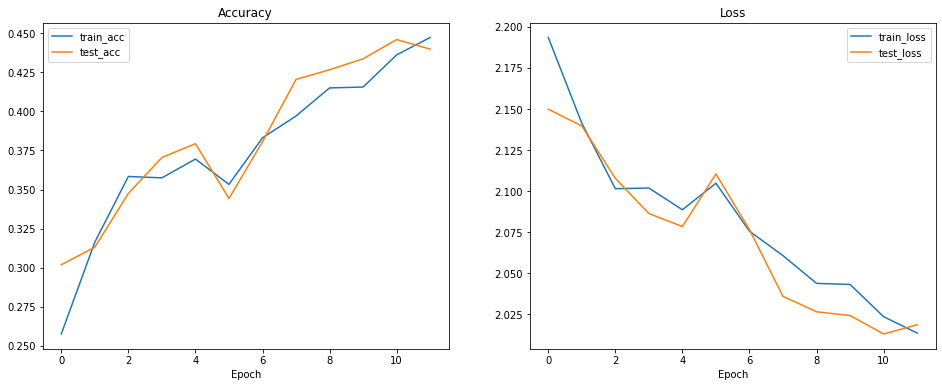

In [131]:
net.plot()

## PyTorchLightning

In [7]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

## PyTorchLightning module template:

In [8]:
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F


class LitMobileNet(pl.LightningModule):
    def __init__(self, input_width, classes_count, input_channels=3, width=32):
        super().__init__()
        self.mobile_net = MobileNet(input_width, classes_count, input_channels, width)

    def forward(self, x):
        return self.mobile_net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

In [9]:
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger()

In [10]:
trainer = pl.Trainer(max_epochs=1, accelerator="gpu", gpus=1, logger=wandb_logger)
model = LitMobileNet(32, 10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]

  | Name       | Type      | Params
-----------------------------------------
0 | mobile_net | MobileNet | 3.2 M 
-----------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.869    Total estimated model params size (MB)
/external2/dkkoshman/venv/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ········


wandb: ERROR API key must be 40 characters long, yours was 8
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/dkkoshman/.netrc
wandb: ERROR Unable to read ~/.netrc


In [11]:
trainer.fit(model, train_dataloaders=train_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]

  | Name       | Type      | Params
-----------------------------------------
0 | mobile_net | MobileNet | 3.2 M 
-----------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.869    Total estimated model params size (MB)
/external2/dkkoshman/venv/lib/python3.6/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /external2/dkkoshman/Notebooks/ML/None/version_None/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/external2/dkkoshman/venv/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve 

Training: 0it [00:00, ?it/s]